## 0. Introduction

A pacemaker is a small device that's placed (implanted) in the chest to help control the heartbeat. It's used to prevent the heart from beating too slowly. Implanting a pacemaker in the chest requires a surgical procedure. The presense of a pacermaker on ECG is manifested by stimulation artifacts as demonstrated in the image bellow:
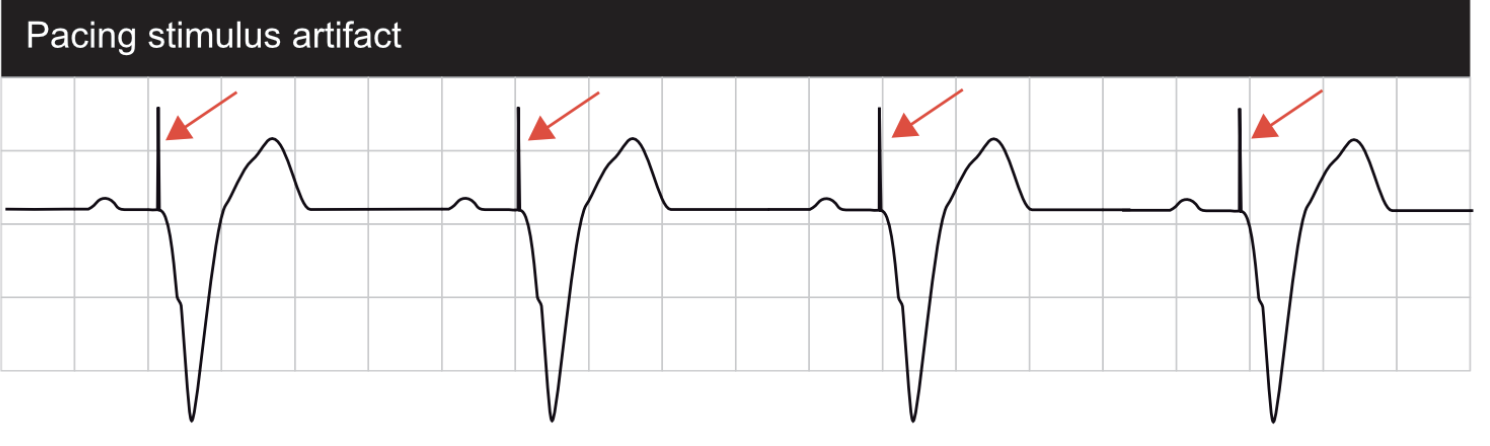


In this mini-project you will be asked to create an algorithm to classify ECG records with a pacemaker and analyse its perofrmance. 

You can write your code directly in this notebook.

Please pay attention to writing a clean code following best coding practices.

## 1. Load Data

In [ ]:
# download the PTB-XL dataset
!wget https://physionet.org/static/published-projects/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1.zip
## unzip folders
!unzip ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1.zip


In [ ]:
# install a package to read and process signals in WFDB format
!pip install wfdb
# install a package to plot
!pip install matplotlib==3.1.3
# install neurokit2  package to analysis and processing\cleaning ecg
!pip install neurokit2


## 2. Load libraries

In [ ]:
import ast
import wfdb
import numpy as np
import pandas as pd
from zlib import crc32
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import *
import scipy.fftpack
import neurokit2 as nk

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from tensorflow.keras.backend import clear_session

## 3. Auxiliary Functions

In [ ]:
# plot ECG signal from a signal lead
def plot_lead(lead_signal, sampling_rate):
    min_y = 0.1 * (lead_signal.min() // 0.1)
    max_y = 0.1 * ((lead_signal.max() // 0.1) + 1)
    min_x = 0
    max_x = len(lead_signal) / sampling_rate
    xbins = np.arange(len(lead_signal)) / sampling_rate

    fig = plt.figure(figsize=(25, 1.5))
    ax = fig.add_subplot(111)
    ax.plot(xbins, lead_signal)
    ax.set_xlim(0, max_x)

    xmajor = np.arange(min_x, max_x + 0.04, 0.2)
    xminor = np.arange(min_x, max_x + 0.04, 0.04)
    ymajor = np.arange(min_y, max_y + 0.1, 0.5)
    yminor = np.arange(min_y, max_y + 0.1, 0.1)

    ax.set_xticks(xminor, minor=True)
    ax.set_xticks(xmajor, minor=False)

    ax.set_yticks(yminor, minor=True)
    ax.set_yticks(ymajor, minor=False)

    ax.grid(which="minor", color="red", linewidth=0.3)
    ax.grid(which="major", color="red", linewidth=0.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    return fig, ax

In [ ]:
# create a table (dataframe) based on the downloaded PTB-XL dataset
def gen_df_base(ptbxl_root: Path) -> pd.DataFrame:
    ptbxl_root = Path(ptbxl_root)
    df_ptbxl = pd.read_csv(ptbxl_root / "ptbxl_database.csv", dtype={"patient_id": int})
    df_scp = pd.read_csv(ptbxl_root / "scp_statements.csv", index_col=0)

    def aggregate_subclass(y_dic, agg_df):
        tmp = []
        for key in y_dic.keys():
            if key in agg_df.index:
                tmp.append(agg_df.loc[key].diagnostic_subclass)
        return list(set(tmp))

    def aggregate_class(y_dic, agg_df):
        tmp = []
        for key in y_dic.keys():
            if key in agg_df.index:
                tmp.append(agg_df.loc[key].diagnostic_class)
        return list(set(tmp))

    def aggregate_diagnostic(y_dic):
        tmp = []
        for key in y_dic.keys():
            tmp.append(key)
        return list(set(tmp))

    df_ptbxl.scp_codes = df_ptbxl.scp_codes.apply(lambda x: ast.literal_eval(x))
    df_scp = df_scp[df_scp.diagnostic == 1]
    df_ptbxl["diagnostic_subclass"] = df_ptbxl.scp_codes.apply(lambda x: aggregate_subclass(x, df_scp))
    df_ptbxl["diagnostic"] = df_ptbxl.scp_codes.apply(lambda x: aggregate_diagnostic(x))
    df_ptbxl["diagnostic_class"] = df_ptbxl.scp_codes.apply(lambda x: aggregate_class(x, df_scp))

    return df_ptbxl

Prepare data table (dataframe)

In [ ]:
ptbxl_root = Path("/content/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1")
df = gen_df_base(ptbxl_root)

In the data table (df) the diagnostic labels are found in the column "diagnostic". The pacemaker is denoted by the string "PACE"; if the string "PACE" is among the diagnostic labeles in a specific row, it means that the corresponding ECG record belongs to a patient with a pacemaker.

## Task 1:

* Add a new column "has_pacemaker" to the datadrame df with True for ECG records with a pacemaker and False otherwise.
* Can you think why using the "diagnostic" column to infere the pacemaker label may be better than using the "pacemaker" column directly? Explain

In [ ]:
# check which rows the contain the 'PACE' string in diagnostic column and assign to a new coulmn 'has_pacemaker' True if exsit otherwise (o.w) False
df.insert(31,"has_pacemaker",df['diagnostic'].str.contains('PACE', regex=False))

The reasons why we would like to infer the pacemaker label from the “diagnostic” rather than the “pacemaker” column are:

* First, We wish to compare the quality of the two columns ('scp_codes'/'diagnostic' and 'pacemaker'), in the dataset documentation, we can see that the 'diagnostic' column infers from the 'report' column, which contains more about the patient information rather than the 'pacemaker' column.
* Second, the SCP-ECG statements are written as a dictionary with entries of the form 'statement: likelihood', where the likelihood is set to 0 if unknown, therefore we have a softer decision regarding the presence of a pacemaker, rather than just 'NaN' or 'ja' (yes in German). The motivation for using such a likelihood mechanism is that for some physicians the pacemaker signal could be described as other diagnostic due to 'pacemaker' failure, problem in the device ECG, or a wrong ECG test and vice versa.
    * Remark: now, there are just two values of pacemaker likelihood, 0 and 100. Nevertheless, this structure lets us have the ability in the future to have more decision degrees of freedom (soft) in our analysis.

## Task 2: Perform exploraroty analysis of the data in the table

* Analyse the distribution of age, sex, weight, recording date.
* Can you think of other interesting questions that could be asked about the data in the table?

In [ ]:
# taking just the relevant data 
df_display=df[['age','weight','recording_date']]
# convert the recording_date to displayable format
df_display["recording_date"] = df_display["recording_date"].astype("datetime64")
df_display["recording_date"].groupby([df_display["recording_date"].dt.hour])
df_display.hist(bins=15,figsize=(15,15))


* **Age**: 
  * Mean: 60
  * STD: 17
  * The values span from: 2 to 85 years old, while statiscally speaking the ages are mainly between 43-77 years old.
* **Sex**: 
  * 48.0% Female 
  * 52.0% Male
* **Weight**: 
  * Mean: 71 
  * STD: 16
  * The weight span from: 5 to 250 kg, while statiscally speaking the weight are mainly between 55-87 kg.
* **Recording Date**:
 * We can see that the months and the days are likely to be a bit random, most of the recording done between 1990-1997 and between 08:00-14:00.

* There are more insightful statistics that we can derive from the data:
  *  What is the percentage of true pacemaker labels among the all dataset?
    * 1.34%
    * We see that our dataset in relatively lean for pacemaker classification, (this insight will appear also in Task 4 as part of our performance analysis).
  * How many of the true pacemaker labels are inferred with other diagnostics among the total true pacemaker label? and among the all dataset?
    * 6.8% from the true pacemaker
    * 0.09% from the all dataset
    * This conclusion can tell if we can say something about the 
      pacemaker miss-detection from other diagnostics—in this case it will be very hard.
  * How many dataset samples are reassured by a physician's second opinion?
    * 2.5%
  * How many samples within the true pacemaker labels have been reassured by a physician's second opinion?
    * 0%
  * **Diversity**: May effect on how our data is bias and also about the pacemaker classification results—we will examine the percentage among the all dataset and the percentage from the pacemaker true labels:
    * **Patients**: we wish to make sure that the data (has_pacemakr: false\true) data is diverse for example that all the data has been taken from the same person (it the worst case).
      * How many patients the dataset contains?
        * 18885 different patients (out of 21837)
        * typical (mean) appearance: 1.15
        * appearance deviation: 0.5
      * How many patients among the true label pacemaker dataset contains?
        * 237 different patients (out of 296)
        * typical (mean) appearance: 1.24
        * appearance deviation: 0.6
      * Conclusion: we see that our patient data is diverse.
    * **ECG device**:
        * How many ECG devices the dataset contains?
          * 11 different ECG device (out of 21837 exams)
          * The maximum ECG device which appears 28.11% from the total tests is: 'CS100-3' then devices 'CS-12' and 'AT-6-C-5.5' with 18% and the 8 rest devices are 36%.
        * How many patients among the true label pacemaker dataset contains?
          * 10 different sites (out of 296 exams and 11 total sites)
          * The maximum ECG device which appears 65.5% from the total tests is: 'CS100-3' then device 'CS-12' with 8% and the 8 rest devices are 27%.
        * Conclusion: we see that our data *(mainly the 'has_pacemaker')* is highly dependent in the performance of device 'CS100-3'.
    * **Site**:
        * How many sites the dataset contains?
          * 51 different sites (out of 21837 exams)
          * The maximum site which appears 41% from the test is: 0 then site 1 with 28% and 2 with 23% the 48 rest site are just 8%.
        * How many patients among the true label pacemaker dataset contains?
          * 9 different sites (out of 296 exams and 51 total sites)
          * The maximum site which appears 66% from the test is: 0 then site 1 with 13% and 2 with 10% the 6 rest sites are just 11%.
        * Conclusion: we see that our data (mainly the 'has_pacemaker') is highly dependent on site 0 and partly in site 1 and 2.
    * **Nurse**:
        * How many nurses the dataset contains?
          * 12 different nurses (out of 21837 exams)
          * The maximum nurse which appears 38% from all the tests is: 0 then site 1 with 26% and the rest nurses sharing the other 35% evenly.
        * How many patients among the true label pacemaker dataset contains?
          * 11 different sites (out of 296 exams and 12 total sites)
          * The maximum nurse, which appears 66.8% from all the tests is: 0 then site 1 with 12.5% and the rest nurses sharing the other 20.7% evenly.
        * Conclusion: we see that our data (mainly the 'has_pacemaker') is highly dependent on nurse 0 and partly in nurse 1.

***Remark***: I don't put the analysis source code for the above section—I mainly used in value_counts(), mean(), std() dataframe functions and a simple percentage calculations. My data exploration orientation was to analysis the mean and std in each section and if I see large std relative to the mean I apply values_count() and some statistics to gain better understating about the different cases.

### Visualize ECG records w\o pacemaker

Run the following cells to examine examples with and without a pacemaker. Do you see the difference?

**Indeed, we can see a visible delta function which may imitate the Sinoatrial Node action (QRS segment).**

In [ ]:
filename = df[df["has_pacemaker"]]["filename_hr"].values[0]
record = wfdb.rdrecord((ptbxl_root/filename).as_posix())
fix,ax  = plot_lead(record.p_signal[:,2],record.fs)

In [ ]:
filename = df[~df["has_pacemaker"]]["filename_hr"].values[6]
record = wfdb.rdrecord((ptbxl_root/filename).as_posix())
fix,ax  = plot_lead(record.p_signal[:,2],record.fs)

## Split Data - Train and Test

**Remark**: According to the dataset/article: (https://www.nature.com/articles/s41597-020-0495-6#Sec5)
* The ninth (2194 samples, 26 samples with true pacemaker labels) and tenth (2204 samples, 28 samples with true pacemaker labels) fold are folds with a particularly high label quality that are supposed to be used as validation and test sets.
* The relation between the true pacemaker labels remain relative the same as the total folds number.
* "We propose to use the tenth fold, which is ensured to contain only ECGs that have certainly be validated by at least one human cardiologist and are therefore presumably of highest label quality, to separate a test set that is only used for the final performance evaluation of a proposed algorithm. The remaining nine folds can be used as training and validation set and split at one’s own discretion, potentially utilizing the recommended fold assignments. As the ninth and the tenth fold satisfy the same quality criteria, we recommend to use the ninth fold as validation set." - more explanation regard the folds selection and preferences inside the article.

In [ ]:
import pandas as pd
from pathlib import Path
import wfdb  
import numpy as np
from typing import Tuple

# using the 100 Hz records
sampling_rate: int = 100
# used the Cross-Validation Folds recommandation from the dataset website
test_fold: int = 10


def load_raw_data(df: pd.DataFrame, sampling_rate: int, path: Path) -> np.ndarray:
    if sampling_rate == 100:
        data = np.array([wfdb.rdsamp(str(path) + "/" + f) for f in df.filename_lr])
    else:
        data = np.array([wfdb.rdsamp(str(path) + "/" + f) for f in df.filename_hr])
    data = np.array([signal for signal, meta in data])
    return data


def data_prep(
    df: pd.DataFrame, path: Path
) -> Tuple[np.ndarray, pd.DataFrame, np.ndarray, pd.DataFrame]:
    raw_ecg_signal = load_raw_data(df, sampling_rate, path)
    # Train
    raw_ecg_signal_train = raw_ecg_signal[np.where(df.strat_fold != test_fold)]
    labels_train = df[(df.strat_fold != test_fold)].has_pacemaker
    # Test
    raw_ecg_signal_test = raw_ecg_signal[np.where(df.strat_fold == test_fold)]
    labels_test = df[df.strat_fold == test_fold].has_pacemaker
    return raw_ecg_signal_train, labels_train, raw_ecg_signal_test, labels_test


In [ ]:
# call the data prep function
data_train, label_train, data_test, label_test = data_prep(df, ptbxl_root)

## CONVERTING INPUT IMAGES TO CONV LAYER INPUT FORMAT
xtrain = data_train.reshape(data_train.shape[0], data_train.shape[1], data_train.shape[2], 1)
xtest = data_test.reshape(data_test.shape[0], data_test.shape[1], data_test.shape[2], 1)

## converting output into interger values False : 0, True : 1
ytrain = label_train.map({False : 0, True : 1})
ytest = label_test.map({False : 0, True : 1})

## one hot encoding of output to make model ready data
y_train = tf.keras.utils.to_categorical(ytrain , num_classes=2)
y_test = tf.keras.utils.to_categorical(ytest , num_classes=2)

## Preprocessing ECG data - Clean/Peak Enhancement signal using extarnal libary (Optional):
https://neurokit2.readthedocs.io/en/latest/index.html
* Using butterworth IIR filter

In [ ]:
# Define a new function
def ecg_pacemaker_preprocessing(ecg_signal,sampling_rate=100):
    ecg_cleaned = nk.ecg_clean(ecg_signal, sampling_rate)
    return ecg_cleaned

wfdb_sample_data=xtrain[100,:,0]
sampling_rate=100
wfdb_sample_data_clean= ecg_pacemaker_preprocessing(wfdb_sample_date,sampling_rate)

## plot loss and accuracy
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].plot(wfdb_sample_data, label = 'raw data')
ax[0].set_title("ECG data-PTB-XL")
ax[0].legend()

ax[1].plot(wfdb_sample_data_clean, label = 'clean data')
ax[1].set_title("ECG data clean-NeuroKit")
ax[1].legend()


**Remarks**: 
* In case we wish to apply nk.ecg_clean on the entire data use:
  * xtrain_clean=np.apply_along_axis(ecg_pacemaker_preprocessing, 1, xtrain)
* I checked the performance of the model with the clean data—I don't see any improvement—this has been one of my ways to examine methods to get better confusion matrix.

## Task 3 

Build a classifier to descriminate between ECG records with and without a pacemaker
* You can use any approach you want.
* Solving the problem with a Convolution Neural Network (CNN) will grant you with extra credit (Hint: you can adapt standard architectures, however a simple network with few convolitional and maxpool layers will give good enough results for this problem).
* If you choose the CNN approach you can use either Keras or Pytorch (If you donj't have preferences for a specific framework, Keras is preferable) .
* Explain in details your solution and be ready to defend it.

In [ ]:
def conv_model(input_shape):

    model = Sequential() ## creating a sequential model

    ## 1st convolution layer with 16-> filter and (3,3) -> kernel size
    model.add(Conv2D(16, (3,3), activation = 'relu', input_shape =input_shape))
    ## adding maxpool layer with size/pool size (2,2)
    model.add(MaxPooling2D(pool_size =(2,2)))

    ## 2nd convolution layer with 16-> filter and (3,3) -> kernel size
    model.add(Conv2D(16, (3,3), activation = 'relu'))
    ## adding maxpool layer with size/pool size (2,2)
    model.add(MaxPooling2D(pool_size = (2,2)))
    
    ## flattening the layer
    model.add(Flatten())

    ## dense layer to finetune model
    model.add(Dense(128, activation='relu'))
    ## output layer
    model.add(Dense(2, activation='sigmoid'))

    return model

* **Model explanation**:

  * I've created a convolution neural network based model with 2 convolution layers and 2 maxpooling layer.
  * Applied flat layer to get all features into one dimension. 
  * Applied one dense layer.
  * To fine tune the model and finally output layer with 2 neurons (True, False) is being added.
  * Throughout the model, I have used relu activation.

In [ ]:
## get model object
model = conv_model((xtrain.shape[1], xtrain.shape[2],1))

## compiling model with log loss/binary cross entropy, accuracy score , and adam optimizer
model.compile(loss = "binary_crossentropy", metrics = ['accuracy'], optimizer='adam')

## training model for 10 epochs
history = model.fit(xtrain, y_train, validation_data = (xtest, y_test), batch_size=32, epochs = 10, verbose=1)

In [ ]:
model.summary()

In [ ]:
## plot loss and accuracy
fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].plot(range(1,11), history.history['loss'], label = 'train loss')
ax[0].plot(range(1,11), history.history['val_loss'], label = 'test loss')
ax[0].set_title("loss plot")
ax[0].legend()

ax[1].plot(range(1,11), history.history['accuracy'], label = 'train accuracy')
ax[1].plot(range(1,11), history.history['val_accuracy'], label = 'test accuracy')
ax[1].set_title("accuracy plot")
ax[1].legend()

plt.show()

## Task 4
Analyse the performance of your classifier
* Plot the ROC curve.
* Provide the standard performance metrics: specificity, sensitivity, AUC.
* Suggest a working point threshold.
* Analyse the errors of your model: what are the reasons for false pos/neg?
* Discuss how would you improve your classifier if you had more time.

In [ ]:
yprediction_train = model.predict(xtrain) ## getting train data prediction as probabilites
ytrain_pred = [np.argmax(i) for i in yprediction_train] ## getting a list of output values

In [ ]:
yprediction = model.predict(xtest) ## getting test data prediction as probabilites
ytest_pred = [np.argmax(i) for i in yprediction] ## getting a list of output values

In [ ]:
print(classification_report(ytest, ytest_pred))
print(classification_report(ytrain, ytrain_pred))

In [ ]:
## getting tpr, fpr scores wit threshold for test data
fpr_te, tpr_te, threshold_te = roc_curve(ytest,  yprediction[:, 1])

auc_test = auc(fpr_te, tpr_te)
print(f"auc score for test data is {auc_test:.4f}")

optimal_idx = np.argmax(tpr_te - fpr_te)
optimal_threshod_test = threshold_te[optimal_idx]
print("Test Threshold value is:", optimal_threshod_test)

In [ ]:
## getting tpr, fpr scores wit threshold for train data
fpr_tr, tpr_tr, threshold_tr = roc_curve(ytrain,  yprediction_train[:, 1])

auc_train = auc(fpr_tr, tpr_tr)
print(f"auc score for train data is {auc_train:.4f}")

optimal_idx = np.argmax(tpr_tr - fpr_tr)
optimal_threshod_train = threshold_tr[optimal_idx]
print("Train Threshold value is:", optimal_threshod_train)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(fpr_tr, tpr_tr, label = "train")
plt.plot(fpr_te, tpr_te, label = "test")
plt.legend()
plt.ylabel('True Positive Rate/Sensitivity')
plt.xlabel('False Positive Rate/(1-Specificity))')
plt.title('ROC Curve')
plt.show()

In [ ]:
print("Train Confusion Matrix")
print(confusion_matrix(ytrain, ytrain_pred))

In [ ]:
print("Test Confusion Matrix")
print(confusion_matrix(ytest, ytest_pred))

[*Note—Majority Class (No peacemaker), Minority Class (Yes peacemaker)*]

* **Analysis Model Errors**:
  * The model has trained the training data in such as way that the minority class (Peacemaker—Yes) has 100% accuracy whereas the majority class(Peacemaker - No) has also generated 99.99% accuracy. 
  * Surprisingly there is no misclassification for minority class and False Positive is 12, whereas False negative is 0.
  * When we compare the train result with the test data, there is a huge misclassification for minority class which indicates model is overfitting 
  (not able to replicate the results from train data into test data for minority class) resulting the False Negative as 12 (41%), whereas the majority class has no effect(False Positive 0.22%) and performing well.
  * Overall, the model performance on test data as compared to training data is not satisfactory.

* **Model Improvement**:

  * We can improve the model by adding more minority class data to the dataset, so that we can make the classes a balanced dataset to some extent.

  * We can add or remove layers from the model and experiment different set of parameters to get an optimal model.

## Task 5

Model deployment


The model you developed and tested is going to be deployed in a hospital. Every ECG record obtained in this hospital should pass through the model and output a notification in case a pacemaker is present. Note that the real production envrionment is noisy and you will need to deal with different outliers and exceptions.

* Discuss how would you deploy the model in production; suggest a high level design of the production pipiline that cover possible edge cases.
* How would you monitor the performance of your model? Which caveats would you expect?
* **Bonus**: implement a production level system that wraps your model. Specifially, given an input signal and its metadata (e.g. age, sex, scan date, etc) the system checks if the patient is above 18 years old, if yes it applies the pacemaker algorithm and returns an output object containing the algorithm result (True/False), patient age, and scan date; otherwise it throws an exception and returns the output object with patient age, scan date and empty algorithm result.

* *Discuss how would you deploy the model in production; suggest a high level design of the production pipeline that cover possible edge cases*:

  In case we wish to deploy model in production we need to consider the 
  following:
  * Tracking:
    * Using version control—to tracking the: data, model architectures, hyperparameters, and external software. Specifically, we can use model registry model location, information on how to reproduce the training environment, references to the training data and more.
    * DevOps:
      * CI/CD—automate builds and deployments.
      * Package models appropriately—Model Deployed as a Service—create thin microservice thin that consumes features as input and serves model predictions.
  * Monitoring:
      * Develop and deploy a logging module—also send some alert in case there are some errors.
      * Measure the system reliability—uptime and how the system response to requests.
  * Reliability:
    * Deploy on reliable infrastructure: container—easy to develop a CI/CD, region flexibility and more.
    * Unit tests and end-to-end tests.

  After we understood the building blocks above, we wish to discuss on how and with which tools we prefer to use.

  The ECG application must be reliable therefor deploy it on-premises isn't a good idea, moreover in case we wish to do so, the IT team in the hospital must be professional, and we assume that it's may not be the case. Therefore, using not-manage services, as self develop Kubernetes platform can be irrelevant.
  Hence, we choose to work with one of the largest cloud providers: AWS, Azure, GCP self-managed services to reassure reliability, cost and performance.

  *Assumptions*:
  1. The data/metadata send to cloud from the device.
  2. We need to consider multiple devices (5000+).
  3. We have development/staging/production environment.

  *High Level Design*:
  1. Development environment :
    * Working we source control and CI—test/build the relevant docker images.
    * Build the relevant pipeline: 
      * Data—validation, preprocessing, model training, model analysis.
    * For this case we need to use some 'cold-storage' (Azure Blob, S3), to save the model that we serve to the production environment, the data in each phase—we need to keep the data dirty for further use.
    * For each one of these pipelines, we need to write automation and testing.
  2. Staging/production environment:
    * contain the same data pipeline as above with adding module of data extraction—fetch and organized the data in the relevant directory, db or storage.
    * Model registry, save a version of the trained model and the metadata.
    * Deploy the predication service with relevant updated model.
    * Performance monitoring module—evaluate the reality and accuracy of the predication service and model.
  3. We wish to add to our data pipeline, a DSP module which use filtering to clean the ECG signal.
  4. To send the data in real time we prefer to use Websocktes, 
  updates are sent immediately when they are available, and we don't need to wait—it can also serve as a base protocol on which to implement device management frameworks, to configure the device from remote.


*How would you monitor the performance of your model? Which caveats would you expect?*
* Performance monitoring:
  *  Customize triggers to notify you when there are significant changes in metrics such as accuracy, precision.
  * Try to understand if the performance aren't stable and have a specific pattern, if it's the case we need to design more robust model that will have better overall performance.
  * Check and monitoring on data that the model performance are poor.
  * Pay attention to the metadata values: change in the ECG devices, recording date—nurse and hospital team aren't focus enough and more metadata that indicate that we need to tune our models.
* Which caveats would you expect?:
  * ECG data access and model sharing.
  * Limited flexibility of pre-existing IT infrastructures and teams.
  * The datasets cloud be fetched from a single source, therefore an overfitting and generalizing poorly can be occurred—as we saw in our exploration.


### **Bonus**:
* **Framework and Infrastructure**:
  * Flask framework for the web application.
  * Poetry, Python for dependency management and packaging.
  * AWS EC2 t2.micro instance.

* **Major Steps**:
  1. Develop the model on jupyter notebook (colab) .
  2. Setup a develop enviorment using Keras container enviorment 'honghu/keras' via WSL 2 docker enviorment (optiontional).
  3. Install the releveant packages and develop the web application server-side code.
    * Using flake8 to check the code style and quality (pep8).
    * Still need to add mypy for type-check and fix the relevant problems and add relevant unitests. 
  4. Write scripts for development and deployment enviorment using shell.
  5. Configure the relevant EC2 machine (security group, packages installtion).
  6. Build the docker images using the relevant docker file.
    * Build the container image from 'python:3.6-slim' source image.
  7. Deploy the docker container on AWS EC2 (t2.micro).
    * Test the application from the local machine as a client.
  8. Upload the docker image to dockerhub public repsotory:
    * https://hub.docker.com/repository/docker/sagiezri/ecg_pacemaker_classifier


* **Prerequisites**:
  * Windows:
    * Install WSL 2 and Docker Desktop on your local windows machine
  * Linux:
    * Install docker packages for the relevant OS.
  * Download the relevant ecg_predict.txt, .dat, .hea files to the local machine
  (from sagi ezri git repostory/assignment email or download and fetch from the dataset).
    * Files location for the curl command: 
      * ecg_pacemaker_mini_project/curl_cmd_files/ 
    * You need the both .dat amd .hea of a specific sample.
    * Create by yourself .txt file, ecg_predict.txt structure (for example):
  
    {

    "recording_date":"01/11/1984  8:27:32",

    "age":19,

    "height":55,

    "weight": 80,

    "nurse": 0,

    "site": 2,

    "device": "CS-12   E",

    "sex": "Male",

    "patient_id": 1

    }


* **Executing program**:
  * Open CMD
  * Run:
    * docker pull sagiezri/ecg_pacemaker_classifier:version1.0
    * sudo docker run -p 80:3000 sagiezri/ecg_pacemaker_classifier:version1.0
  * The docker image should be running automatically and start the service.
  * Configure the .txt file with the relevant parameters.
  * Update the relevant curl command if needed (using other files).
  * Run:
    * Test it on your localhost:
      * curl -F files=@ecg_predict.txt -F files=@00001_lr.dat -F files=@00001_lr.hea http://localhost/predict
    * Test on remote computer:
      * curl -F files=@ecg_predict.txt -F files=@00001_lr.dat -F files=@00001_lr.hea http://server-public-dns/predict
  * In case you wish to check it on my remote machine - ping me and I'll start the instance.